In [88]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(30,30)
plt.rcParams['image.cmap']='gray'
% %matplotlib inline

In [2]:
mnist_data_path='../AI_database/mnist/MNIST_DATA'
def imshow(X,Y=None,classes=None):
    '''
        show Batch of image in grids sqrt(h) x sqrt(w)
        X is a numpy array,size (m,h,w,c)
        Y is a numpy array,size (m,#classes)
    '''
    m=X.shape[0]
    gridSize=int(m**0.5)
    for i in range(0,gridSize):
        for j in range(0,gridSize):
            _idx=i*gridSize+j
            im=X[_idx]
            plt.subplot(gridSize,gridSize,_idx+1)
            plt.axis('off')
            plt.imshow(im)
            if Y is not None:
                label=classes[np.argmax(Y[_idx])]
                plt.title(label)

def load_dataset(flaten=False,one_hot=True):
    def _make_one_hot(d,C=10):
        return (np.arange(C)==d[:,None]).astype(np.int32)

    mnist=input_data.read_data_sets(mnist_data_path)
    X_train,Y_train=mnist.train.images,mnist.train.labels
    X_test,Y_test=mnist.test.images,mnist.test.labels

    if flaten==False:
        X_train=X_train.reshape((-1,28,28,1))
        X_test = X_test.reshape((-1, 28, 28,1))
    if one_hot:
        Y_train = _make_one_hot(Y_train)
        Y_test=_make_one_hot(Y_test)


    print('\n-------------------------------------------------------------------------')
    print('load %d train Example,%d Test Example'%(X_train.shape[0],X_test.shape[0]))
    print('Train Images  Shape:'+str(X_train.shape))
    print('Train Labels  Shape:' + str(Y_train.shape))
    print('Test  Images  Shape:'+str(X_test.shape))
    print('Test  Labels  Shape:' + str(Y_test.shape))
    print('-------------------------------------------------------------------------')
    return (X_train,Y_train,X_test,Y_test)

In [3]:
X_train,Y_train,X_test,Y_test=load_dataset(flaten=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting ../AI_database/mnist/MNIST_DATA/train-images-idx3-ubyte.gz
Extracting

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


 ../AI_database/mnist/MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-labels-idx1-ubyte.gz

-------------------------------------------------------------------------
load 55000 train Example,10000 Test Example
Train Images  Shape:(55000, 784)
Train Labels  Shape:(55000, 10)
Test  Images  Shape:(10000, 784)
Test  Labels  Shape:(10000, 10)
-------------------------------------------------------------------------


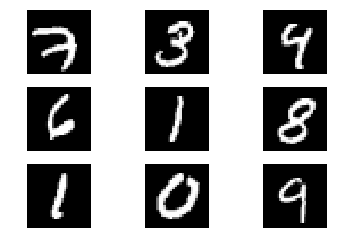

In [4]:
imshow(X_train[0:9].reshape(-1,28,28))

## Above is prepared Data
### First Try to build a discriminatior ,this is a classifer that can tell whether it's a real or fake image
### I try 2layer Neural Network

In [162]:
def discriminatior(X):
    '''
        X:is a Image,shape (?,784)
    '''

    with tf.variable_scope('discriminative',reuse=tf.AUTO_REUSE):
        X=tf.contrib.layers.fully_connected(X,128,activation_fn=tf.nn.relu,weights_initializer=tf.contrib.layers.xavier_initializer()) #should have shape [?,128]
        X=tf.contrib.layers.fully_connected(X,1) #should have shape [?,1]
    return X

In [163]:
#for simply I defina a generator
def getNext(X,batch=128):
    X=X.copy()
    
    m=X.shape[0]
    real_batch=batch//2
    np.random.shuffle(X)
    
    while True:
        iters=2*m//batch
        for i in range(iters):
            xs=np.random.rand(batch,784)
            ys=np.zeros((batch,1),dtype=np.bool)
            
            xs[0:real_batch]=X[i*real_batch:(i+1)*real_batch]
            ys[0:real_batch]=1
            yield (xs,ys)

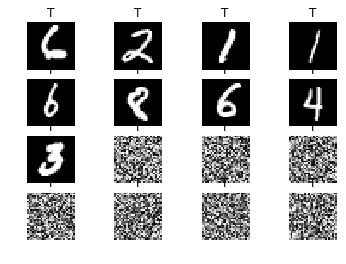

In [164]:
gen=getNext(X_train,batch=18)
aa=next(gen)
imshow(aa[0].reshape(-1,28,28),aa[1],['T','XXXXX'])

In [165]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

X=tf.placeholder(shape=[None,784],dtype=tf.float32)
Y_hat=discriminatior(X)

Y=tf.placeholder(shape=[None,1],dtype=tf.bool)
predict=Y_hat>0.5
accuracy=tf.reduce_mean(tf.cast(tf.equal(Y,predict),tf.float32))

loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Y_hat,labels=tf.cast(Y,tf.float32)))
optimizer=tf.train.AdamOptimizer(1e-4).minimize(loss)


In [166]:
def train(model,Xdata,Ydata,steps,epoch=10,print_every=100):
    X,Y,opt,loss,accuracy=model
    tf.global_variables_initializer().run()
    for e in range(epoch):
        for i in range(steps):
            xs,ys=next(gen)
            _,_loss=sess.run([opt,loss],feed_dict={X:xs,Y:ys})
            if (i==0 or i%print_every==0):
                if i==0:
                    acc=accuracy.eval(feed_dict={X:Xdata,Y:Ydata})
                    print('epoch %d,acc: %f'%(e,acc))        
                print('----->',np.round(_loss,4))
    
                

In [174]:
m=X_train.shape[0]

Xdata=np.random.rand(2*m,784)
Ydata=np.zeros((2*m,1),dtype=np.float32)
Xdata[0:m]=X_train
Ydata[0:m]=1

train([X,Y,optimizer,loss,accuracy],Xdata,Ydata,steps=m//128,epoch=20)

ValueError: could not broadcast input array from shape (10000,784) into shape (55000,784)

In [171]:
predict.eval(feed_dict={X:X_test[0:10]})

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

In [173]:
predict.eval(feed_dict={X:np.random.rand(10,784)})

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]], dtype=bool)